<a href="https://colab.research.google.com/github/MuftiqurBista1111/Unisnacks_Data_Forecasting/blob/main/LSTM_14_04_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from datetime import date
import datetime
from dateutil.relativedelta import relativedelta
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
# import pmdarima as pm
import itertools
import math
import matplotlib.pyplot as plt


from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
data = pd.read_csv("/content/Sales Order Custom Search Bista Results - 747 - Revised.csv", parse_dates=True)


In [3]:

data_new = data.loc[:,['Customer Name','Date','Quantity','Item : Internal ID']]
data_new.rename(columns={'Item : Internal ID': 'Product_Id', 'Name':'Customer_Name'}, inplace=True)
# Drop rows with NaN values in Product_Id column
data_new.dropna(subset=['Product_Id'], inplace=True)

result = data_new.groupby(['Customer Name', 'Product_Id', 'Date', 'Quantity']).size().reset_index()

In [4]:
# Define your function to load and preprocess data
def preprocess_data(file_path):
    # Load data
    data = pd.read_csv(file_path, parse_dates=True)

    # Select relevant columns and rename
    data_new = data.loc[:,['Customer Name','Date','Quantity','Item : Internal ID']]
    data_new.rename(columns={'Item : Internal ID': 'Product_Id', 'Customer Name':'Customer_Name'}, inplace=True)

    # Drop rows with NaN values in Product_Id column
    data_new.dropna(subset=['Product_Id'], inplace=True)

    # Group by Customer Name, Product_Id, Date, and Quantity
    result = data_new.groupby(['Customer_Name', 'Product_Id', 'Date', 'Quantity']).size().reset_index()

    return result

In [32]:
def get_customer_product_data(data):
    # Initialize an empty dictionary to store customer-wise dataframes
    customer_dataframes = {}

    # Initialize empty lists to store customer names and product IDs with more than 15 entries
    selected_customers = []
    selected_products = []

    # Iterate over unique customers
    unique_customers = data['Customer_Name'].unique()
    for customer in unique_customers:
        # Filter data for the current customer
        customer_data = data[data['Customer_Name'] == customer]

        # Iterate over unique products purchased by the customer
        unique_products = customer_data['Product_Id'].unique()
        for product in unique_products:
            # Filter data for the current product
            product_data = customer_data[customer_data['Product_Id'] == product]

            # Check if the number of entries for the product is more than 15
            if len(product_data) > 15:
                # Extract date and quantity information for the product
                product_sales_data = product_data[['Date', 'Quantity']]

                # Add the customer and product to selected lists
                selected_customers.append(customer)
                selected_products.append(product)

                # Add the product sales data to the dictionary using customer and product as keys
                customer_dataframes[(customer, product)] = product_sales_data

    return selected_customers, selected_products, customer_dataframes


In [33]:
# Load and preprocess your data (replace 'file_path' with your actual file path)
file_path = "/content/Sales Order Custom Search Bista Results - 747 - Revised.csv"
result = preprocess_data(file_path)

# Get selected customers and products
selected_customers, selected_products, customer_product_data = get_customer_product_data(result)

# Display selected customers and products
print("Customers and Product IDs with total sales quantity more than 15:")
for customer, product in zip(selected_customers, selected_products):
    print(f"Customer: {customer}, Product: {product}")

Customers and Product IDs with total sales quantity more than 15:
Customer: ABX001 Matthews Foods- Aberdeen, Product: 423.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 424.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 442.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 443.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 444.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 445.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 460.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 469.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 480.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 481.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 487.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 488.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 490.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 492.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 493.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 494.0
Custom

In [106]:
def get_customer_product_dataframe(customer, product, customer_product_data):
    return customer_product_data.get((customer, product), None)

# Example: Select a specific customer and product
selected_customer = "WXX018 Xingja Reunion Co. Ltd T/A Tianfu"
selected_product = 480.0

# Get date and quantity DataFrame for the selected customer and product
selected_dataframe = get_customer_product_dataframe(selected_customer, selected_product, customer_product_data)

# Update the 'Quantity' column of selected_dataframe to have all values as 1
selected_dataframe['Quantity'] = 1

# Print the DataFrame
if selected_dataframe is not None:
    print(f"\nDate and Quantity DataFrame for Customer: {selected_customer}, Product: {selected_product}:")
    print(selected_dataframe)
else:
    print(f"No data found for Customer: {selected_customer}, Product: {selected_product}")



Date and Quantity DataFrame for Customer: WXX018 Xingja Reunion Co. Ltd T/A Tianfu, Product: 480.0:
              Date  Quantity
382524  03/07/2021         1
382525  04/06/2021         1
382526  10/12/2019         1
382527  14/04/2021         1
382528  14/09/2020         1
382529  18/02/2022         1
382530  19/02/2021         1
382531  20/08/2019         1
382532  21/09/2022         1
382533  23/04/2021         1
382534  29/10/2019         1
382535  29/10/2021         1
382536  30/03/2022         1
382537  30/04/2022         1
382538  30/09/2020         1
382539  31/10/2022         1


In [107]:
import datetime
from dateutil.relativedelta import relativedelta

# Define the operation to create a DataFrame for 5 years data with all zeros
today = datetime.date.today()
end_date = today.replace(day=1) - datetime.timedelta(days=1)
start_date = end_date + relativedelta(years=-5)
date_range = pd.date_range(start=start_date, end=end_date, freq="Q")
new_df = pd.DataFrame({'Date': date_range.strftime('%d/%m/%Y'), 'Quantity': 0.00})

# Convert 'Date' column to object data type
new_df['Date'] = new_df['Date'].astype('object')

# Convert 'Quantity' column to float64 data type
new_df['Quantity'] = new_df['Quantity'].astype('float64')

# Print the new DataFrame
print("New DataFrame:")
print(new_df)


New DataFrame:
          Date  Quantity
0   30/06/2019       0.0
1   30/09/2019       0.0
2   31/12/2019       0.0
3   31/03/2020       0.0
4   30/06/2020       0.0
5   30/09/2020       0.0
6   31/12/2020       0.0
7   31/03/2021       0.0
8   30/06/2021       0.0
9   30/09/2021       0.0
10  31/12/2021       0.0
11  31/03/2022       0.0
12  30/06/2022       0.0
13  30/09/2022       0.0
14  31/12/2022       0.0
15  31/03/2023       0.0
16  30/06/2023       0.0
17  30/09/2023       0.0
18  31/12/2023       0.0
19  31/03/2024       0.0


In [108]:
# Merge new_df with selected_dataframe
merged_df = pd.concat([new_df, selected_dataframe], ignore_index=True)

# Convert 'Date' column to datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%d/%m/%Y')

# Fill NaN values with 0.00 for Quantity
merged_df['Quantity'].fillna(0.00, inplace=True)

# Sort the DataFrame by the 'Date' column
merged_df = merged_df.sort_values(by='Date')

# Print the merged and sorted DataFrame
print("Merged and Sorted DataFrame:")
print(merged_df)


Merged and Sorted DataFrame:
         Date  Quantity
0  2019-06-30       0.0
27 2019-08-20       1.0
1  2019-09-30       0.0
30 2019-10-29       1.0
22 2019-12-10       1.0
2  2019-12-31       0.0
3  2020-03-31       0.0
4  2020-06-30       0.0
24 2020-09-14       1.0
34 2020-09-30       1.0
5  2020-09-30       0.0
6  2020-12-31       0.0
26 2021-02-19       1.0
7  2021-03-31       0.0
23 2021-04-14       1.0
29 2021-04-23       1.0
21 2021-06-04       1.0
8  2021-06-30       0.0
20 2021-07-03       1.0
9  2021-09-30       0.0
31 2021-10-29       1.0
10 2021-12-31       0.0
25 2022-02-18       1.0
32 2022-03-30       1.0
11 2022-03-31       0.0
33 2022-04-30       1.0
12 2022-06-30       0.0
28 2022-09-21       1.0
13 2022-09-30       0.0
35 2022-10-31       1.0
14 2022-12-31       0.0
15 2023-03-31       0.0
16 2023-06-30       0.0
17 2023-09-30       0.0
18 2023-12-31       0.0
19 2024-03-31       0.0


In [109]:
# Convert 'Date' column to datetime dtype if it's not already
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Set 'Date' column as the index
merged_df.set_index('Date', inplace=True)

# Define a function to aggregate the data and cap it at 1
def aggregate_and_cap(x):
    # Calculate the sum of the values and cap it at 1 if greater than 1
    aggregated_value = min(x.sum(), 1)
    return aggregated_value

# Resample the DataFrame according to quarters and apply the function
try:
    quarterly_df = merged_df.resample('Q').apply(aggregate_and_cap)
except KeyError as e:
    print(f"Error: {e} column not found.")

# Reset the index to make 'Date' a column again
quarterly_df.reset_index(inplace=True)

# Print the resampled DataFrame
print(quarterly_df)


         Date  Quantity
0  2019-06-30       0.0
1  2019-09-30       1.0
2  2019-12-31       1.0
3  2020-03-31       0.0
4  2020-06-30       0.0
5  2020-09-30       1.0
6  2020-12-31       0.0
7  2021-03-31       1.0
8  2021-06-30       1.0
9  2021-09-30       1.0
10 2021-12-31       1.0
11 2022-03-31       1.0
12 2022-06-30       1.0
13 2022-09-30       1.0
14 2022-12-31       1.0
15 2023-03-31       0.0
16 2023-06-30       0.0
17 2023-09-30       0.0
18 2023-12-31       0.0
19 2024-03-31       0.0


Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2536
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2280
Epoch 3/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2060
Epoch 4/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1798
Epoch 5/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1474
Epoch 6/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1099
Epoch 7/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0730
Epoch 8/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0446
Epoch 9/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0272
Epoch 10/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0178
Epoch 11/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0125
Epoch 12/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0093
Epoch 13/50
1/1 [==============================] - 0s 26ms/step

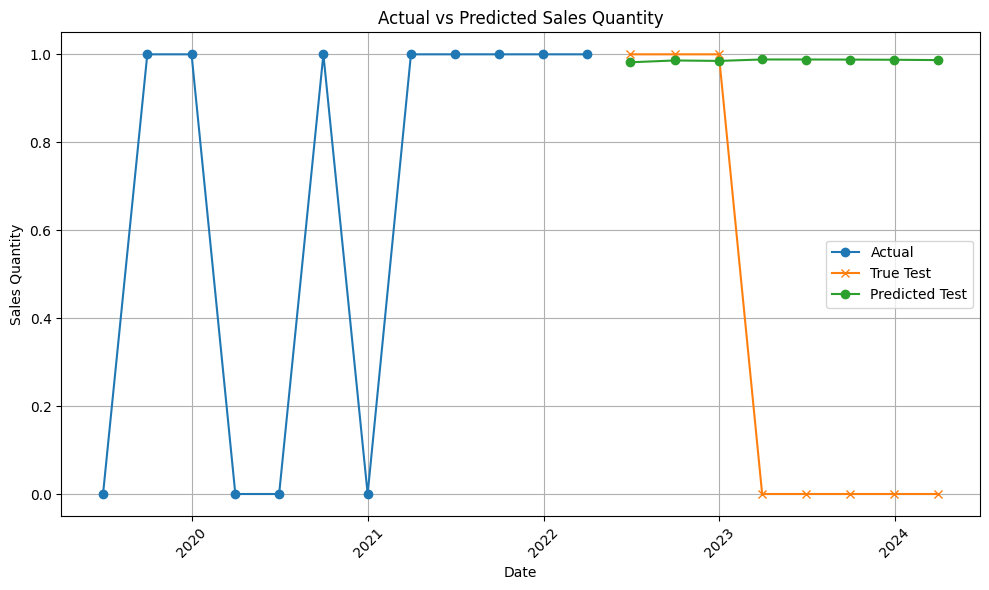

In [112]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop

# Set random seed for reproducibility
np.random.seed(42)

# Assuming you have quarterly_df already defined

# Convert quarterly_df to a numpy array
data = quarterly_df['Quantity'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define sequence length
seq_length = 8

# Create sequences
X, y = [], []
for i in range(len(scaled_data) - seq_length):
    X.append(scaled_data[i:i + seq_length])
    y.append(scaled_data[i + seq_length])

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
# Split the data into training and testing sets
split_index = len(X) - 8
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape input data to be 3D for LSTM [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model with more layers and RMSprop optimizer
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
optimizer = RMSprop(lr=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=1)

# Make predictions on test data
predictions_scaled = model.predict(X_test)

# Inverse transform the scaled predictions
predictions = scaler.inverse_transform(predictions_scaled)

# Evaluate model
mse = mean_squared_error(y_test, predictions_scaled)
print("Mean Squared Error:", mse)

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(quarterly_df['Date'][:-8], quarterly_df['Quantity'][:-8], label='Actual', marker='o')
plt.plot(quarterly_df['Date'][-8:], scaler.inverse_transform(y_test), label='True Test', marker='x')
plt.plot(quarterly_df['Date'][-8:], predictions, label='Predicted Test', marker='o')
plt.title('Actual vs Predicted Sales Quantity')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [113]:
import pandas as pd

# Get dates corresponding to test data
test_dates = quarterly_df['Date'][-8:]


# Apply threshold condition to predictions
threshold = 0.3
adjusted_predictions = predictions.copy()
adjusted_predictions[adjusted_predictions > threshold] = 1

# Create a DataFrame with the data to be saved
result_df = pd.DataFrame({
    'Date': test_dates,
    'Predicted': predictions.flatten(),
    'Adjusted': adjusted_predictions.flatten(),
    'Actual': quarterly_df['Quantity'].iloc[-8:].values
})


# Print the full quarterly_df
print("Full quarterly_df:")
print(quarterly_df)

# Print the result DataFrame containing predictions and actual values
print("\nResult DataFrame:")
print(result_df)

# Open a text file in write mode
with open('sales_predictions3.txt', 'w') as f:
    # Write header information
    f.write("Customer Name: {}\n".format(selected_customer))
    f.write("Product ID: {}\n".format(selected_product))
    f.write("\n")

    # Write quarterly sales data
    f.write("Quarterly Sales Data:\n")
    f.write(quarterly_df.to_string(index=False))
    f.write("\n\n")

    # Write adjusted predictions and corresponding quarterly_df values for comparison
    f.write("Date\t\t\tPredicted\tAdjusted\tActual\n")
    for i in range(len(predictions)):
        f.write("{}\t{}\t{}\t\t{}\n".format(test_dates.iloc[i].strftime('%Y-%m-%d'), predictions[i][0], adjusted_predictions[i][0], quarterly_df['Quantity'].iloc[-8 + i]))

# Print confirmation message
print("Data saved successfully.")


Full quarterly_df:
         Date  Quantity
0  2019-06-30       0.0
1  2019-09-30       1.0
2  2019-12-31       1.0
3  2020-03-31       0.0
4  2020-06-30       0.0
5  2020-09-30       1.0
6  2020-12-31       0.0
7  2021-03-31       1.0
8  2021-06-30       1.0
9  2021-09-30       1.0
10 2021-12-31       1.0
11 2022-03-31       1.0
12 2022-06-30       1.0
13 2022-09-30       1.0
14 2022-12-31       1.0
15 2023-03-31       0.0
16 2023-06-30       0.0
17 2023-09-30       0.0
18 2023-12-31       0.0
19 2024-03-31       0.0

Result DataFrame:
         Date  Predicted  Adjusted  Actual
12 2022-06-30   0.981882       1.0     1.0
13 2022-09-30   0.986011       1.0     1.0
14 2022-12-31   0.984996       1.0     1.0
15 2023-03-31   0.988261       1.0     0.0
16 2023-06-30   0.988189       1.0     0.0
17 2023-09-30   0.988003       1.0     0.0
18 2023-12-31   0.987619       1.0     0.0
19 2024-03-31   0.986872       1.0     0.0
Data saved successfully.
